## Align images by shifting and rotating to a reference frame

In [1]:
# Useful packages

import matplotlib.pyplot as plt
import glob,scipy
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
import numpy as np
import scipy.ndimage as snd
from scipy import optimize
from scipy import signal

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Read in H-alpha images of M51, taken during different years

rootdir = 'm51_different_years/'
files = np.array(glob.glob(rootdir+'*.fit'))
file_names = np.array([file.split('/')[-1] for file in files])

print(files)
print(file_names)

['m51_different_years/2018_300sHa.00000090.M_51.fit'
 'm51_different_years/2012_M51_H_alpha.00000001.M_51.fit'
 'm51_different_years/2016_M51_Ha.00000003.M_51.fit']
['2018_300sHa.00000090.M_51.fit' '2012_M51_H_alpha.00000001.M_51.fit'
 '2016_M51_Ha.00000003.M_51.fit']


13.351155453616888
246.6277266777654


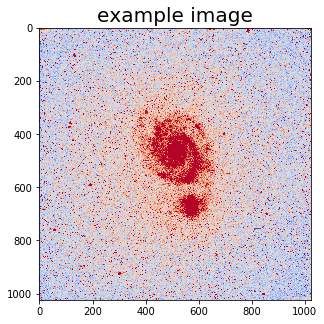

In [3]:
# Read the data into an array

all_frames = []
for file in files: all_frames.append(fits.getdata(file))

# Display an image
data   = all_frames[0]
stats  = sigma_clipped_stats(data,sigma=3,iters=3)
median = stats[1]
sigma  = stats[2]
plt.figure(figsize=(5,5))
plt.imshow(data,vmin=median-3*sigma,vmax=median+3*sigma,cmap=plt.cm.coolwarm)
plt.title('example image',fontsize=20)

print(sigma)
print(np.std(data))

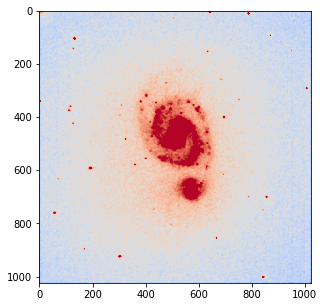

In [4]:
# Apply a median filter to each frame
# This will reduce noise and make it easier to identify stars

# Warning: this may take a while!

n_med = 7  # Median filter by n_med x n_med pixels
filtered_frames = []
for frame in all_frames: filtered_frames.append(signal.medfilt(frame,n_med))

plt.figure(figsize=(5,5))
plt.imshow(filtered_frames[0],vmin=median-3*sigma,vmax=median+3*sigma,cmap=plt.cm.coolwarm)


Text(0.5,1,'image 0 - aligned image 1')

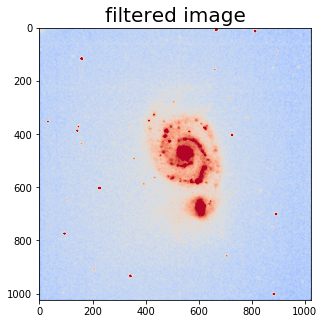

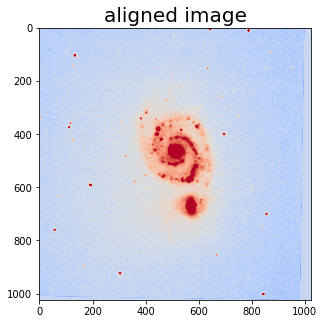

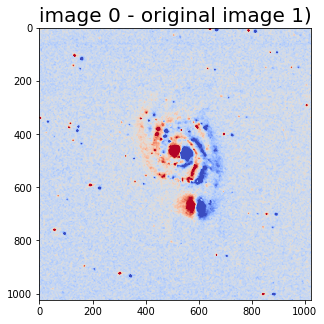

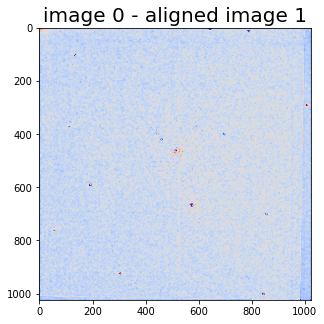

In [5]:
# Align images using the astroalign package, available at 
# https://github.com/toros-astro/astroalign

import astroalign as aa

# Test example: align the first two images

test = aa.register(filtered_frames[1], filtered_frames[0])

plt.figure(figsize=(5,5))
plt.imshow(filtered_frames[1],vmin=median-3*sigma,vmax=median+5*sigma,cmap=plt.cm.coolwarm)
plt.title('filtered image',fontsize=20)

plt.figure(figsize=(5,5))
plt.imshow(test,vmin=median-3*sigma,vmax=median+5*sigma,cmap=plt.cm.coolwarm)
plt.title('aligned image',fontsize=20)

plt.figure(figsize=(5,5))
plt.imshow(filtered_frames[0] - filtered_frames[1],vmin=-3*sigma,vmax=3*sigma,cmap=plt.cm.coolwarm)
plt.title('image 0 - original image 1)',fontsize=20)

plt.figure(figsize=(5,5))
plt.imshow(filtered_frames[0] - test,vmin=-3*sigma,vmax=3*sigma,cmap=plt.cm.coolwarm)
plt.title('image 0 - aligned image 1',fontsize=20)


Text(0.5,1,'aligned image 2')

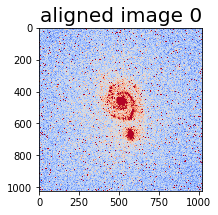

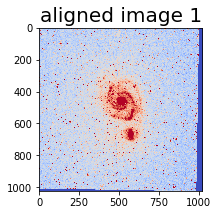

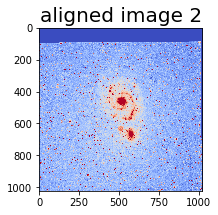

In [6]:
# Align all images

# Find the appropriate transformations, using median-filtered images
reference_image = filtered_frames[0]
transforms = []
for frame in filtered_frames:
    trans, (s_list, t_list) = aa.find_transform(frame, reference_image)
    transforms.append(trans)

# Apply inverse transformations to the original images
# Save the results as FITS files
import skimage
aligned_images = []
outdir = rootdir+'aligned/'
for elt in np.arange(len(all_frames)):
    corr = skimage.transform.warp(all_frames[elt], transforms[elt].inverse, preserve_range=True)
    aligned_images.append(corr)
    fits.writeto(outdir+'aligned_'+file_names[elt], corr, overwrite=True)


# Display aligned images
plt.figure(figsize=(3,3))
plt.imshow(aligned_images[0],vmin=median-3*sigma,vmax=median+5*sigma,cmap=plt.cm.coolwarm)
plt.title('aligned image 0',fontsize=20)

plt.figure(figsize=(3,3))
plt.imshow(aligned_images[1],vmin=median-3*sigma,vmax=median+5*sigma,cmap=plt.cm.coolwarm)
plt.title('aligned image 1',fontsize=20)

plt.figure(figsize=(3,3))
plt.imshow(aligned_images[2],vmin=median-3*sigma,vmax=median+5*sigma,cmap=plt.cm.coolwarm)
plt.title('aligned image 2',fontsize=20)
